### Lab 6: Spectral analysis of paleoclimate data

This lab is a bit different than labs we've done in the past; here, most (but not all) of the code is written for you. Your job today will be to **clearly comment the existing code** -- what is the code doing, and why? -- and **respond to the short answer questions**.

#### Warm-up: Bar chart of causal mechanisms for PETM

Based on the data on the board, create a bar chart of how many students picked each of the different causal mechanisms for the PETM. 

Text(0.5, 0, 'Explanation')

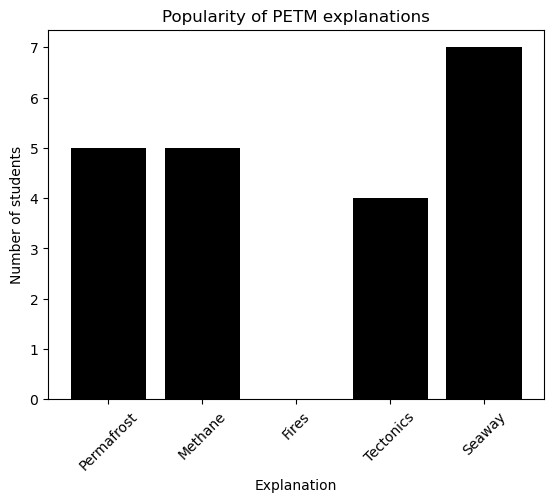

In [1]:
import matplotlib.pyplot as plt

names = ["Permafrost", "Methane", "Fires", "Tectonics", "Seaway"]
counts = [5, 5, 0, 4, 7]

plt.bar(names, counts, color='k')
plt.xticks(names, rotation=45)

plt.title("Popularity of PETM explanations")
plt.ylabel("Number of students")
plt.xlabel("Explanation")

#### Installing and importing packages

For today's lab, you will need to install some new packages that aren't included in the standard version of Anaconda. Open up 'Anaconda Prompt'.

In this window that pops up, type `pip install pyleoclim` and hit enter. Wait for the new package to install.

Do the same for a package called `pooch` and a package called `tempfile`. 

After these are complete, restart your Jupyter Notebook.

In [2]:
import pooch
import os
import tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyleoclim as pyleo

#### Loading and inspecting data

In [3]:
def pooch_load(filelocation=None, filename=None, processor=None):
    
    user_temp_cache = tempfile.gettempdir()  # Create cache for storing temp files? 
    
    #  Retrieve file from given location without a security hash. 
    #  Then make the filename the path of the temp directory appended to filename with OS appropriate separators
    #  Dunno what processor does
    file = pooch.retrieve(
        filelocation,
        known_hash=None,
        fname=os.path.join(user_temp_cache, filename),
        processor=processor,
    )

    return file

`Pyleoclim` is a Python package used to analyze paleoclimate data. You can check out the [documentation for Pyleoclim here](http://linked.earth/PyleoTutorials/intro.html).

Today, we'll be using the benthic $\delta^{18}$O stack from [Lisecki and Raymo (2005)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004PA001071#palo1186-bib-0019). 

In [4]:
filename_LR04 = "LR04.csv"  # Set filename (which doesn't actually matter)
url_LR04 = (
    "https://raw.githubusercontent.com/LinkedEarth/PyleoTutorials/main/data/LR04.csv"
)  #  Give URL of data from Pyleoclim people
lr04_data = pd.read_csv(
    #  Get the data from the Github servers and put in cache before reading to Pandas dataframe
    pooch_load(filelocation=url_LR04, filename=filename_LR04), skiprows=4
)

# Print a couple rows of data to see what's up
lr04_data.head()

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03


**Inspect the data. What are the units of each column?**

Time is in thousands of years ago, benthic $\delta^{18}$O and standard error are both in parts per thousand.

In [5]:
ts_lr04 = pyleo.Series(
    time=lr04_data["Time (ka)"],  # Give time values
    value=lr04_data["Benthic d18O (per mil)  "],  # Give benthic delta O18 values
    time_name="Age",  # Time label
    time_unit="kyr BP",  # Time in thousands of years before present
    value_name="Benthic d18O (per mil)",  # Data label
    value_unit="\u2030",  # Benthic delta O18 in per thousand
    label="LR04",  # Timeseries label
)

Time axis values sorted in ascending order


/tmp/ipykernel_7565/3740012189.py:1: UserWarning: auto_time_params is not specified. Currently default behavior sets this to True, which might modify your supplied time metadata.  Please set to False if you want a different behavior.
  ts_lr04 = pyleo.Series(


**For both the entire record (0 to 5 Ma) and just the last 1 million years (0 to 1 Ma), use the plot generated by the code below to answer the following questions:**

1. **Why does the y-axis go from high to low (inverted)?** Our guess is that because $\delta^{18}$O is inversely related to temperature, inverting the y-axis allows us to visualize temperature by proxy. This holds no matter the time scale.

2. **What patterns do you observe in the record?** Over the last million years, the curve is characterized by sharp peaks followed by slower dropoffs, with varying frequency and amplitude. Over the last five million years, $\delta^{18}$O has generally increased.

3. **Does the amplitude of the variations change over time?** The amplitude of the variations seems to generally increase, both over the last million and last five million years.

4. **At what frequency do the variations occur?** While it is hard to give estimates about frequency over the last five million years, the frequency seems to have dropped off, as we can begin to see separate lines as time progresses. We can give estimates over the last million years: before 600 kyr ago, the frequency was one cycle every ~60 kyr, and after 600 kya, the frequency decreased one cycle every ~100 kyr.


Set slice to 0 to 1 Ma (= 1000 ka) when you're done inspecting the dataset.

<Axes: xlabel='Age [kyr BP]', ylabel='Benthic d18O (per mil) [‰]'>

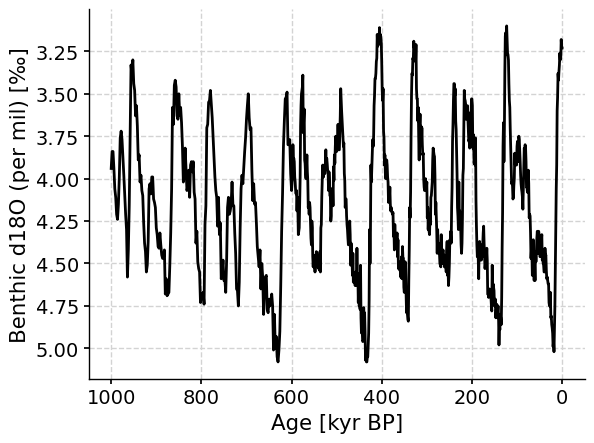

In [6]:
# consider data from now to 1 Ma (or 5000 for 5 Ma)
t0 = 0
t1 = 1000

lr04_slice = ts_lr04.slice([t0, t1])  # get the desired data
fig, ax = plt.subplots()  # create subplots
# Plot lr04 on the ax axes without a legend, with inverted x- and y-axes, in black.
lr04_slice.plot(ax=ax, legend=False, invert_yaxis=True, invert_xaxis=True, color='k')

#### Calculating temperature from $\delta^{18}$O

Write a Python function to calculate temperature given $\delta^{18}$O, and note any assumptions needed to perform this calculation. Calculate and plot temperature for the whole $\delta^{18}$O record from Lisecki and Raymo (2005).

Visit [this link](https://www.danielgaskell.com/d18O/about.html
) for the equation.



Text(0, 0.5, 'Deep sea temperature (°C)')

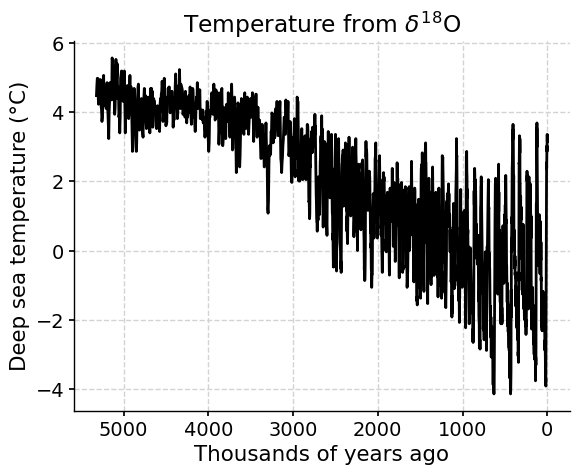

In [7]:
# Assume seawater has same d18O as present. Might not be an appropriate assumption
d18O_sw = 0

def calc_d18O_T(d18O_min):
    # Return calculated temperature based on d18O of mineral samples using given equation
    return 16.1 - 4.64*(d18O_min - d18O_sw - 0.27) + 0.09*(d18O_min - d18O_sw - 0.27)**2

# Create an empty list to store temperatures
T_list = []

# Iterate through the mineral d18O records, calculating temperature estimate and appending it to the list
for i in lr04_data['Benthic d18O (per mil)  ']:
    T_estimate = calc_d18O_T(i)
    T_list.append(T_estimate)

# Plot time on the x-axis and our generated temperature estimates on the y-axis, in black.
plt.plot(lr04_data['Time (ka)'], T_list, color='k')
plt.gca().invert_xaxis()  # Invert the x-axis so time advances to the right. Add title and axes labels as usual
plt.title("Temperature from $\delta^{18}$O")
plt.xlabel("Thousands of years ago")
plt.ylabel("Deep sea temperature (\N{DEGREE SIGN}C)")

**Just looking at the time period from today to 1 Ma, what temperature is the record varying between? What do you make of this?**

The deep sea temperature seems to vary between 4$^\circ$C and -4$^\circ$C. We think it is interesting that the temperature varies so much, it could be that the climate is very dynamical. For the deep sea, we must look at different timescales because they show different superimposed patterns. 

#### Spectral analysis

It looks like the $\delta^{18}$O data is varying somewhat periodically (i.e., not randomly). **Spectral analysis** is a mathematical way to describe the distribution of the variance in the signal as a function of frequency (i.e., determine the frequency(ies) at which this record is varying). This can help us describe recurring patterns in our proxy data and potentially help us identify potential causal mechanisms for changing temperature of the last few million years. 

There are many ways to estimate the spectral density of our data. The `pyleoclim` package has five of these methods built in. You can perform each of these methods by running the code below. A higher PSD (Power Spectral Density) value means that more of the overall signal can be explained by periodic variation with a given period.

<Axes: xlabel='Period [kyr]', ylabel='PSD'>

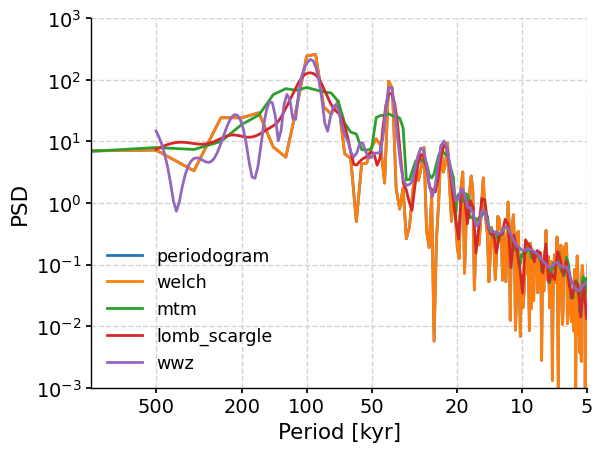

In [8]:
fig, ax = plt.subplots()

'''
In each code block below, the data is standardized before spectral analysis is conducted. 
- The interp() function interpolates the data onto a time axis with a step size of 0.5
- The standardize() function subtracts the mean from the data and then divides the standard deviation
- The spectral() method conducts spectral analysis by the given method
- The plot() plots on the subplot axes the output of the spectral analysis with the given x- and y-axis limits
and appropriate label.

Note: it may be very slightly faster to save the interpolated and standardized data in a variable
so to minimize redundant function calls, at the expense of readability.
'''

# basic periodogram
lr04_slice.interp(step=0.5).standardize().spectral(method="periodogram").plot(
    ax=ax, xlim=[1000, 5], ylim=[0.001, 1000], label="periodogram"
)
# Welch's periodogram
lr04_slice.interp(step=0.5).standardize().spectral(method="welch").plot(
    ax=ax, xlim=[1000, 5], ylim=[0.001, 1000], label="welch"
)
# Multi-taper Method
lr04_slice.interp(step=0.5).standardize().spectral(method="mtm").plot(
    ax=ax, xlim=[1000, 5], ylim=[0.001, 1000], label="mtm"
)
# Lomb-Scargle periodogram
lr04_slice.interp(step=0.5).standardize().spectral(method="lomb_scargle").plot(
    ax=ax, xlim=[1000, 5], ylim=[0.001, 1000], label="lomb_scargle"
)
# weighted wavelet Z-transform (WWZ)
lr04_slice.interp(step=0.5).standardize().spectral(method="wwz").plot(
    ax=ax, xlim=[1000, 5], ylim=[0.001, 1000], label="wwz")

**Compare and contrast the shapes of the PSD plots produced by each spectral analysis method.**

While the overall trend is the same for each model, the sensitivity of each method varies drastically. The WWZ method produces a line with little variation while the Welch method produces a very noisy line, especially for high frequencies. The MTM and Lomb-Scargle methods hit an intermediate noisiness, and we can't see the periodogram line because it is buried by all the others (commenting out all the others shows that Welch's periodogram exactly matches the normal periodogram insofar as the details can be seen by eye).

All of the methods suggest that there are strong peaks around 100 kyr and ~40 kyr, suggesting that proxy data follows cycles of those lengths.

We will use Lomb-Scargle method because it works with unevenly spaced timeseries (common in paleoclimate data -- we don't get to choose the time that our samples represent) and it is relatively fast to compute.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyr]', ylabel='PSD'>)

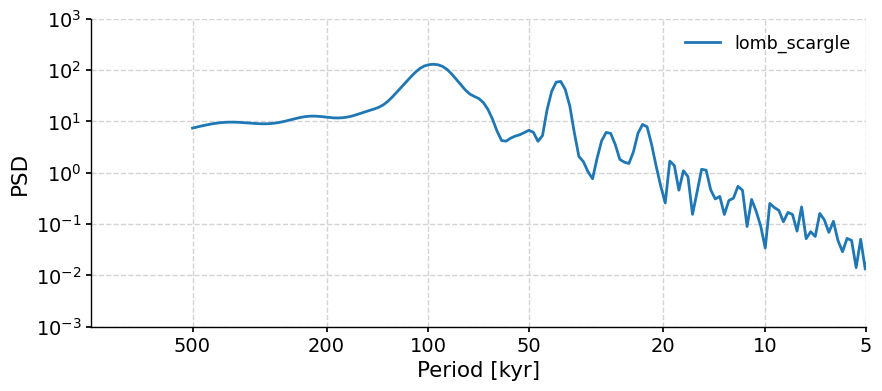

In [9]:
# Lomb-Scargle periodogram using same method as above
lr04_ls_sd = lr04_slice.interp(step=0.5).standardize().spectral(method="lomb_scargle")

# Standard plot which seems to be using matplotlib subplots.
lr04_ls_sd.plot(xlim=[1000, 5], ylim=[0.001, 1000], label="lomb_scargle")

It seems like there are some frequencies with higher spectral density than others. Using a significance test built in to `pyleoclim`, we can test whether these frequencies are statistically significant.

In [10]:
lr04_ls_sd_sig = lr04_ls_sd.signif_test()

# This significance test will tell us which periods have statistically significant PSD values, 
# where statistic significance means that there is less than 5%
# chance the PSD value is due to random variation

Performing spectral analysis on individual series: 100%|█████████████████| 200/200 [00:01<00:00, 116.53it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyrs]', ylabel='PSD'>)

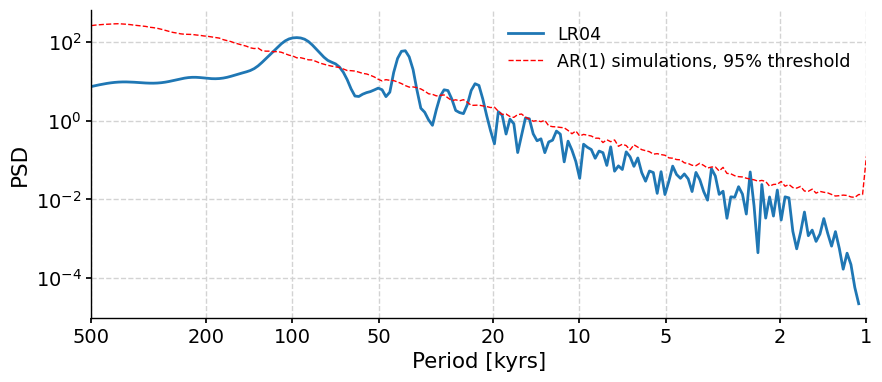

In [11]:
lr04_ls_sd_sig.plot(xlabel="Period [kyrs]")

Peaks that pop out above the dotted red line are statistically significant at the 95% confidence level.

The variable `lr04_ls_sd_sig` contains the significant frequencies of the significant peaks from the spectral density of the LR04 data. We can now create the same plot of spectral power, but with only the significant peaks.

NOTE: For this figure, we will plot the x-axis a bit differently. In the previous plot, the x-axis was the “period” but this time the x-axis will be “frequency”, which is the inverse of the period.

Text(0, 0.5, 'Spectra Amplitude')

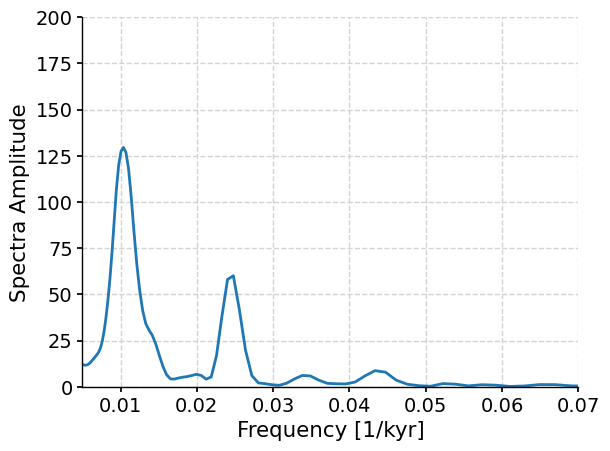

In [12]:
# This plots the significance as a function of frequency, highlighting significant frequencies
# The 'subplots' method is used here with the appropriate 'set_[graph attribute]' methods.

fig, ax = plt.subplots()
ax.plot(lr04_ls_sd_sig.frequency, lr04_ls_sd_sig.amplitude)
ax.set_xlim([0.005, 0.07])
ax.set_ylim([0, 200])
ax.set_xlabel("Frequency [1/kyr]")
ax.set_ylabel("Spectra Amplitude")


**At what frequencies do the largest spectral powers occur?**

The frequency that the largest spectral powers occur at is 0.01 kyr$^{-1}$, and the second most is at 0.025 kyr$^{-1}$. There is also a small blip corresponding to a frequency of about 0.043 kyr$^{-1}$.

**Based on this, what process(es) do you think is/are causing these variations in deep-ocean $\delta^{18}$O?**

Based on these variations the largest spectral power is caused by eccentricity (100,000-year cycle). However, it looks like there is also some influence from obliquity (\~40,000-year cycles). The small blip likely corresponds to precession (\~26,000-year cycles).

**Why would these processes affect global climate?**

Eccentricity changes the orbital pathway that the Earth takes around the sun. This causes different lengths of seasons due to the earth being further or closer to the sun during orbit. 

Obliquity changes the tilt of the earth (22.1-24.5) this then causes changes in the amount of solar radiation hitting different areas. This causes differences in the severity of the seasons.  

Precession changes the point in the orbit at which the seasons occur. The effect this has on global climate depends on eccentricity and obliquity, as the two together determine the lengths of the seasons (ex. whether the Northern Hemisphere or the Southern Hemisphere experiences a long summer). 

Another related tool we can use to learn more about the climate variability recorded in the data is wavelet analysis. This method allows us to “unfold” a spectrum and look at its evolution over time. In other words, wavelet analysis can help us determine changes in the spectral power over time. We don't need to understand the math behind this in this course.

(<Figure size 800x1000 with 4 Axes>,
 {'ts': <Axes: xlabel='Age [kyr BP]', ylabel='Benthic d18O (per mil) [‰]'>,
  'scal': <Axes: xlabel='Age [kyr BP]', ylabel='Scale [kyrs]'>,
  'psd': <Axes: xlabel='Amplitude'>,
  'cb': <Axes: xlabel='cwt Amplitude'>})

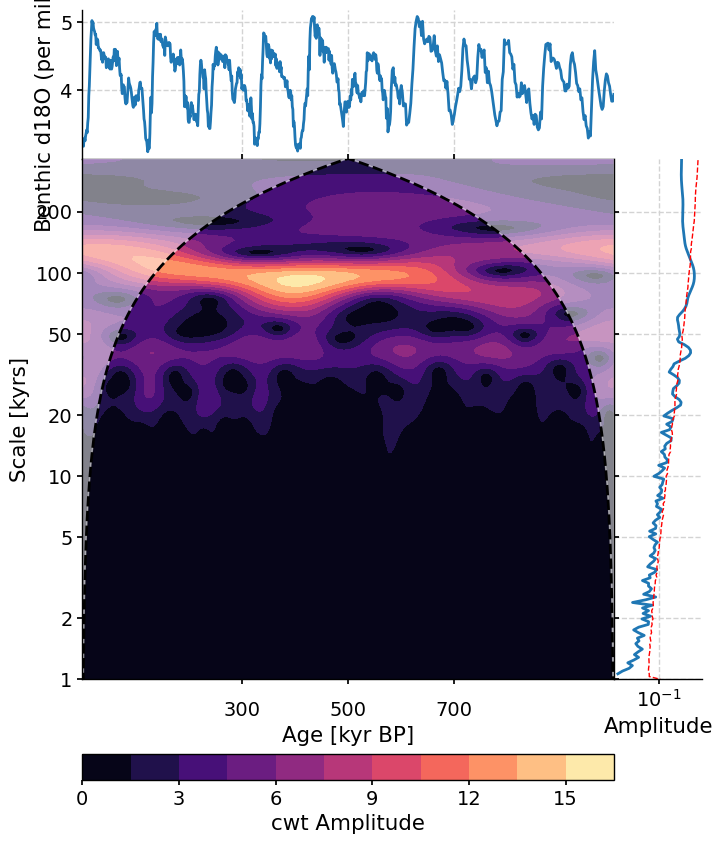

In [13]:
# Conducts wavelet analysis on interpolated, standardized data
scal = lr04_slice.interp(step=0.5).standardize().wavelet()

# make plot
lr04_slice.summary_plot(
    psd=lr04_ls_sd_sig, scalogram=scal, time_lim=[t0, t1], psd_label="Amplitude"
)


**What is this figure telling us?**

This figure is telling us that eccentricity, which operates on a 100ka cycle, is the most significant process. There is another peak at around 40ka which corresponds to the cycles of obliquity. Because they are the two significant processes shown in this figure, we can conclude that eccentricity and obliquity are the most statistically significant factors for deep sea temperatures.

**What are the advantages and disadvantages of using a deep-ocean proxy record (as compared to using a shallow-ocean record)?**

The advantages of using a deep-sea proxy record may include resilience to small changes in climate allowing us to focus on more long-term trends. Deep ocean records may also not be as susceptible to the dissolution of carbonates during periods of high ocean acidification. Shallow-ocean carbonate records are also limited to the tropics with warm areas with high rainfall (necessary for silicate weathering), but deep-ocean records may be available for a wider range of latitudes. Finally, deep ocean records would not be vulnerable to weathering or other effects of the drops in sea level associated with periods of glaciation.

The disadvantages may include limitations on the time periods available to study, as the oldest ocean crust has been subducted. Further, the samples may be affected by diagenesis which could alter the isotopic ratio recorded and lead to proxies being inaccurate. Further, deep-ocean records may be much harder to acquire, requiring more equipment and funding.


#### Detrending data

One of the reasons we chose to focus on just the past 1 Ma in this dataset is that there is a longer-term trend superimposed on the ~10's ka variability we observed with the spectral analysis. To remove this long-term trend so that we can focus on a longer record of the short term variability, we can use a technique called **detrending**. Use the code below to plot the original and detrended data (on the same plot) for the last 5 Ma.

<Axes: xlabel='Age [kyr BP]', ylabel='Benthic d18O (per mil) [‰]'>

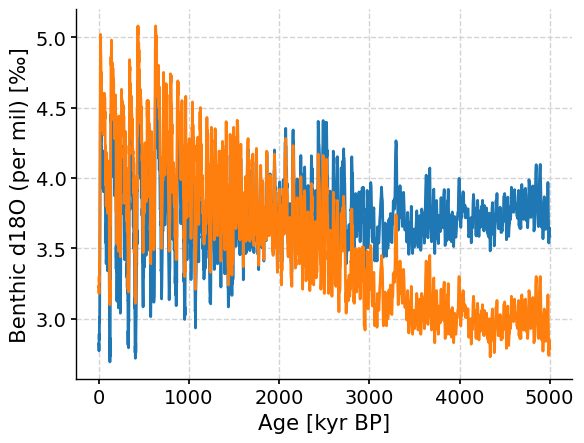

In [14]:
t0 = 0
t1 = 5000

lr04_slice_5Ma = ts_lr04.slice([t0, t1])

lr04_slice_5Ma_detrend = lr04_slice_5Ma.detrend(method='savitzky-golay', preserve_mean=True, keep_log=True)
fig, ax = plt.subplots()

lr04_slice_5Ma_detrend.plot(ax=ax, legend=False, invert_yaxis=True)
lr04_slice_5Ma.plot(ax=ax, legend=False, invert_yaxis=True)

**Create a plot of significant spectra amplitude vs. frequency for the 5 Ma detrended dataset. Which frequencies are statistically significant for this dataset? Is this the same or different than what you found with the 1 Ma dataset? What are the advantages and disadvantages of using the 1 Ma dataset vs. the 5 Ma detrended dataset?**

The statistically significant periods are 40kyr, 26kyr, and 100kyr, but with still significant but less pronounced cycles at 30kyr, and 2.5kyr. Previously, we had seen the 100kyr, 40kyr, and 26kyr periods; the others are new. The advantages of using a longer timescale are that we can recognize processes that may have been significant millions of years ago but have become less influential as time has progressed. 

The disadvantages and advantages of using a longer dataset will depend on the research question. We see different processes becoming more or less relevant over different scales. If you are studying something on a shorter timescale, using the 1 Ma dataset will help eliminate processes that don't matter at this timescale so you can be focused on the processes that matter. If you are studying something on a longer timescale, the 5 Ma dataset will help to show less powerful processes that add up over time to affect your results. 

We saw that precession was not very statistically significant on the 1 Ma timescale, but it mattered a lot more on the 5 Ma dataset. Also, we saw obliquity become the dominant effect at the 5 Ma timescale compared to the 1 Ma time scale where eccentricity had the largest effect. As the global climate changes, the positive feedbacks that serve to amplify these relatively small perturbations will also change; a fuller picture of these small perturbations and the circumstances in which they are more or less significant can only improve our global climate models.

In [15]:
# This line interpolates, standardizes, and conducts a spectral analysis of the detrended 5Ma data
lr04_ls_sd_5Ma_detrend = lr04_slice_5Ma_detrend.interp(step=0.5).standardize().spectral(method="lomb_scargle")

# This line conducts significance tests on the spectral analysis of the detrended 5Ma data
lr04_ls_sd_sig_5Ma_detrend = lr04_ls_sd_5Ma_detrend.signif_test()


Performing spectral analysis on individual series: 100%|██████████████████| 200/200 [00:38<00:00,  5.14it/s]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyrs]', ylabel='PSD'>)

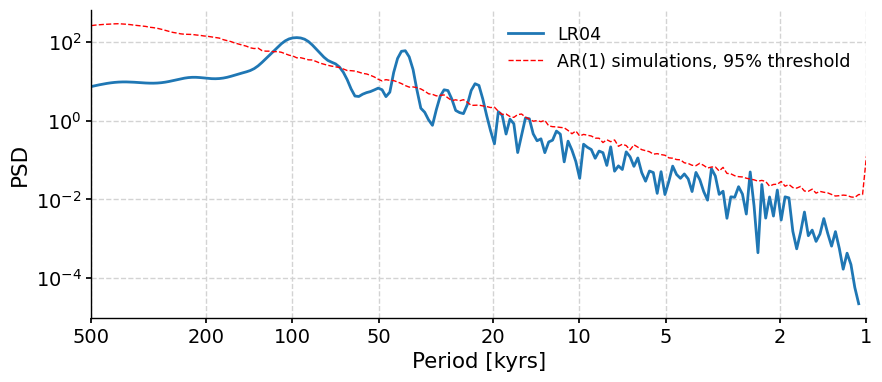

In [16]:
# This code produces a plot of statistical significance by period

lr04_ls_sd_sig.plot(xlabel="Period [kyrs]")

Text(0, 0.5, 'Spectra Amplitude')

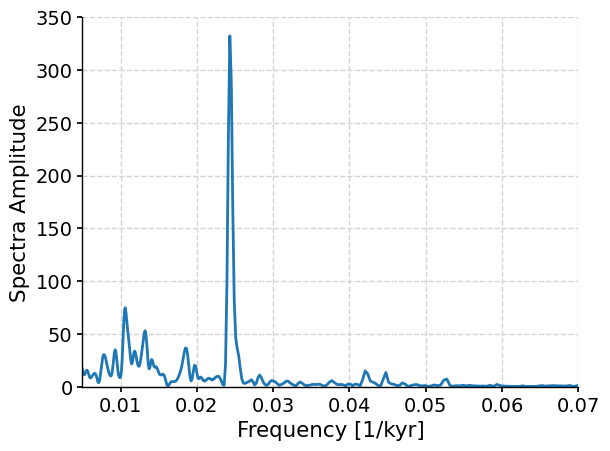

In [17]:
# This generates a spectra amplitude plot for our detrended 5Ma data using the same process as above.

fig, ax = plt.subplots()
ax.plot(lr04_ls_sd_sig_5Ma_detrend.frequency, lr04_ls_sd_sig_5Ma_detrend.amplitude)
ax.set_xlim([0.005, 0.07])
ax.set_ylim([0, 350])
ax.set_xlabel("Frequency [1/kyr]")
ax.set_ylabel("Spectra Amplitude")
